In [1]:
import numpy as np
import random
import warnings
import logging
import math
import luma.emulator.device

# # from ahrs.filters import EKF
# # from scipy.spatial.transform import Rotation as R
# # from ahrs.common.orientation import acc2q

# import skyfield
# from skyfield.api import N, Star, W, E, wgs84, load, load_file
# from skyfield.data import hipparcos, mpc, stellarium
# from skyfield.almanac import find_discrete, risings_and_settings
from pytz import timezone
# from tzwhere import tzwhere

import datetime

# from skyfield.constants import AU_KM
# from skyfield.vectorlib import VectorFunction
# # from spktype01 import SPKType01
# # from jplephem.spk import SPK
# # import ephem
# import warnings
# import numpy as np
# # import networkx as nx

# from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
# from skyfield.projections import build_stereographic_projection

# # from matplotlib.collections import LineCollection

# # import json
# # import pandas as pd

import geomag

# import time

In [2]:
from celestial_compass.observables import ObserverLLA, Observable, ObservableTerrestrialLocation, ObservableSkyObject, ObservableSatellite, ObservableEphemSatellite

In [3]:
from celestial_compass.visibility_window import VisibilityWindow

## WiFi manager
https://github.com/davesteele/comitup

In [4]:
import time
while True:
    print(sensor.euler)
    time.sleep(1)

NameError: name 'sensor' is not defined

## Motor controller tests

In [27]:
from adafruit_motorkit import MotorKit

from adafruit_motor import stepper

In [28]:
motorkit = MotorKit()

stepper_alt = motorkit.stepper2
stepper_az = motorkit.stepper1





In [29]:
direction_alt = stepper.FORWARD
direction_sign_alt = 1
style_alt = stepper.SINGLE


direction_az = stepper.BACKWARD
direction_sign_az = -1
style_az = stepper.SINGLE

In [83]:
# # SINGLE, DOUBLE, INTERLEAVE, MICROSTEP
steps_alt = 256

for _s in range(0,steps_alt):
    # Command
    _o = stepper_alt.onestep(direction=direction_alt, style=style_alt)
#     print(_o)
# stepper_alt.release()


In [30]:
steps_az = int(int(200*16/6)*15/360)


for _s in range(steps_az):
    # Command
    _z = stepper_az.onestep(direction=direction_az, style=style_az)
#     print(_z)
    
# stepper_az.release()

## Arrow controller

In [21]:
from celestial_compass.arrow_controller import ArrowController, sim9dof, simstepper 

In [22]:
ac = ArrowController(simulate_motors=False, simulate_9dof=False)

In [74]:
ac.get_alt_az()

(0.7603090554000298, 1.6849804294090571)

In [4]:
ac.slew_to_alt_az(_alt_rad=1.56, _az_rad=-1)

In [5]:
print(ac.alt_rad)
print(ac.az_rad)

1.5595435460911578
-0.9873863472940452


In [6]:
del ac

## Filters

In [27]:
# num_samples = 1000              # Assuming sensors have 1000 samples each

# acc_data = np.random.random([num_samples, 3])

# gyr_data = np.random.random([num_samples, 3])

In [28]:


# ekf = EKF( Dt=np.random.random())
# Q = np.zeros((num_samples, 4))  # Allocate array for quaternions
# Q[0] = acc2q(acc_data[0])       # First sample of tri-axial accelerometer
# right_ascensions = np.zeros([num_samples,])
# declinations = np.zeros([num_samples,])
# rolls = np.zeros([num_samples,])
# for t in range(1, num_samples):
#     ekf.Dt = np.random.random()
#     Q[t] = ekf.update(Q[t-1], gyr_data[t], acc_data[t])
#     # Quaternion is scalar-first, https://ahrs.readthedocs.io/en/latest/filters/ekf.html
#     # Scipy wants scalar last, https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
#     _rot = R.from_quat([Q[t][1], Q[t][2], Q[t][3], Q[t][0]])
#     [right_ascensions[t], declinations[t], rolls[t]] =_rot.as_euler('ZXY')

In [29]:
# right_ascensions

## Angles

In [5]:
from scipy.spatial.transform import Rotation
import board
import adafruit_bno055

In [6]:
i2c = board.I2C()
bno055 = adafruit_bno055.BNO055_I2C(i2c)

In [39]:
bno055.calibrated

False

In [40]:
bno055.calibration_status  #Tuple containing sys, gyro, accel, and mag calibration data

(0, 3, 0, 0)

In [41]:
_euler_angles_0 = bno055.euler
# We believe the Euler angles are Z, Y, X, with Z up and Y
# The order of the Euler angles is RPY. P is alt, Y is az. ???
# Also note that this is problematic if the base is tilted
_alt_rad_raw = _euler_angles_0[1]*np.pi/180.
_az_rad_raw = _euler_angles_0[2]*np.pi/180.
# TODO check that the numbers are sane! Sometimes this returns numbers outside of 0-360
# TODO correct for magnetic anomaly with
# https://pypi.org/project/geomag/
# Lat in degrees
# Lon in degrees
# El in FEET

# Quaternion is in w, x, y, z format. See table 3-30 in datasheet
_quaternion = bno055.quaternion
# This wants to be in scalar-last format, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
_rotation = Rotation.from_quat([_quaternion[1], _quaternion[2], _quaternion[3], _quaternion[0]])
# TODO this is where we figure out the actual axes based on Section 3.4 in the datasheet
# https://cdn-shop.adafruit.com/datasheets/BST_BNO055_DS000_12.pdf
# Consider a setup with z axis for az and y axis for alt. Then we want z y x, and we will ignore x.
# Based on the markings on the chip: https://www.adafruit.com/product/4646
# This may be Y Z X
_euler_angles = _rotation.as_euler('zyx', degrees=True)

print(bno055.calibrated)
print(_quaternion)
print("THIS MAY BE IT") # and it makes sense. These are extrinsics, so yeah, first turn in elevation (Z), then turn in azimuth around the FIXED azimuth (Y) axis
print( _rotation.as_euler('ZYX', degrees=True))
_euler_angles = _rotation.as_euler('ZYX', degrees=False)
# _alt_rad_raw = _euler_angles[1]
# _az_rad_raw = _euler_angles[0]
print("THESE ARENT")
print( _rotation.as_euler('zyx', degrees=True))
print( _rotation.as_euler('YZX', degrees=True))
print("")
print( _rotation.as_euler('yzx', degrees=True))
print("")
print(_euler_angles_0)

False
(0.70037841796875, -0.7137451171875, -0.003662109375, 0.00286865234375)
THIS MAY BE IT
[ 5.29768094e-01 -5.92878751e-02 -9.10833940e+01]
THESE ARENT
[-6.92942322e-02 -5.28552392e-01 -9.10834395e+01]
[-5.92904095e-02  5.29767811e-01 -9.10828458e+01]

[-5.28552779e-01 -6.92912837e-02 -9.10828003e+01]

(359.5, 0.0, 91.0625)


In [42]:
_quaternion

(0.70037841796875, -0.7137451171875, -0.003662109375, 0.00286865234375)

In [74]:
"""
 Copyright (C) 2021 Federico Rossi (347N)
 
 This file is part of Trovastelle.
 
 Trovastelle is free software: you can redistribute it and/or modify
 it under the terms of the GNU General Public License as published by
 the Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.
 
 Trovastelle is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 GNU General Public License for more details.
 
 You should have received a copy of the GNU General Public License
 along with Trovastelle.  If not, see <http://www.gnu.org/licenses/>.
"""

from celestial_compass.observables import ObserverLLA
import numpy as np
import time
BOARD_AVAILABLE=False
try:
    import board
    import adafruit_bno055    
    BOARD_AVAILABLE=True
except NotImplementedError as e:
    warnings.warn("Not on hardware!")
    board = None

import logging
from adafruit_motorkit import MotorKit

from adafruit_motor import stepper

import geomag
import math

class sim9dof(object):
    def __init__(self, euler: list=(0,0,0)):
        self.euler = euler
        
class simstepper(object):
    def __init__(self):
        self._step = 0
    def onestep(
        self,
        direction,
        style,
    ):
        self._step += 1*direction
        return self._step

class ArrowController(object):
    """
    """
    def __init__(
        self,
        steps_per_turn_alt:int=2052,
        steps_per_turn_az:int=200,
        observer:ObserverLLA=ObserverLLA(
            lat_rad=45.*np.pi/180.,
            lon_rad=8.*np.pi/180.
        ),
        simulate_motors: bool=False,
        simulate_9dof: bool=False
    ):
        self.alt_rad = None
        self.az_rad = None
        self.steps_per_turn_alt = steps_per_turn_alt
        self.steps_per_turn_az = steps_per_turn_az
        self.observer = observer
        
        if simulate_9dof:
            self.bno055 = sim9dof()
        else:
            i2c = board.I2C()
            self.bno055 = adafruit_bno055.BNO055_I2C(i2c)
        
        if simulate_motors:
            self.stepper_alt = simstepper()
            self.stepper_az = simstepper()
        else:
            self.motorkit = MotorKit()
            self.stepper_alt = self.motorkit.stepper2
            self.stepper_az = self.motorkit.stepper1
        
        self.style_alt = stepper.SINGLE
        self.style_az = stepper.SINGLE
        
        if self.style_az == stepper.MICROSTEP:
            self.steps_per_turn_az *= 16
        if self.style_alt == stepper.MICROSTEP:
            self.steps_per_turn_alt *= 16
        
    def __del__(self):
        try:
            self.stepper_alt.release()
        except:
            logging.error("Could not release alt stepper on exit!")
        try:
            self.stepper_az.release()
        except:
            logging.error("Could not release ax stepper on exit!")
        
    def get_alt_az(self):
        _euler_angles = self.bno055.euler
        # We believe the Euler angles are Z, Y, X, with Z up and Y
        # The order of the Euler angles is RPY. P is alt, Y is az. ???
        # Also note that this is problematic if the base is tilted
        _alt_rad_raw = _euler_angles[1]*np.pi/180.
        _az_rad_raw = _euler_angles[2]*np.pi/180.
        
        # Quaternion is in w, x, y, z format. See table 3-30 in datasheet
        _quaternion = self.bno055.quaternion
        # This wants to be in scalar-last format, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
        _rotation = Rotation.from_quat([_quaternion[1], _quaternion[2], _quaternion[3], _quaternion[0]])
        # TODO this is where we figure out the actual axes based on Section 3.4 in the datasheet
        # https://cdn-shop.adafruit.com/datasheets/BST_BNO055_DS000_12.pdf
        # Consider a setup with z axis for az and y axis for alt. Then we want z y x, and we will ignore x.
        # Based on the markings on the chip: https://www.adafruit.com/product/4646
        # This may be Y Z X
#         print( _rotation.as_euler('ZYX', degrees=True))
        _euler_angles = _rotation.as_euler('ZYX', degrees=False)
        _alt_rad_raw = _euler_angles[1]
        _az_rad_raw = -_euler_angles[0]        
        
        # TODO check that the numbers are sane! Sometimes this returns numbers outside of 0-360
        # TODO correct for magnetic anomaly with 
        # https://pypi.org/project/geomag/
        # Lat in degrees
        # Lon in degrees
        # El in FEET
        geo_declination = geomag.declination(
            dlat=self.observer.lat_rad*180./np.pi,
            dlon=self.observer.lon_rad*180./np.pi,
            h=self.observer.alt_m/0.3048
        )
        # mag heading = real heading - decli

        _az_rad_magnetic = _az_rad_raw + geo_declination*np.pi/180.
        # Normalize to selected range
        # Alt: between -pi and pi. If it is outside of -pi/2, pi/2, we are in trouble
        _alt_rad = (math.fmod(_alt_rad_raw+np.pi,2*np.pi)-np.pi)
        if (_alt_rad>np.pi/2.) or (_alt_rad<-np.pi/2.):
            warnings.warn("WARNING: altitude {} is outside of {}-{} range".format(
            _alt_rad,-np.pi/2,np.pi/2))
        # Az: between -pi and pi
        _az_rad = (math.fmod(_az_rad_magnetic+np.pi,2*np.pi)-np.pi)
        print("Azimuth: raw {} deg, corrected {} deg, clamped {} deg".format(
            _az_rad_raw*180/np.pi,
            _az_rad_magnetic*180/np.pi,
            _az_rad*180/np.pi
        ))
        self.alt_rad = _alt_rad
        self.az_rad  = _az_rad
        
        return self.alt_rad, self.az_rad
    
    def calibrate(self, max_tries=3):
        for _try in range(max_tries):
            for _alt in [-np.pi/4, 0, np.pi/4, np.pi/2-0.01,]:
                _starting_az, _starting_alt = self.get_alt_az()
                for _i in range(3):
                    if self.bno055.calibrated is True:
                        continue
                    print(self.bno055.calibration_status)
                    self.slew_to_alt_az(_alt, self.az_rad+2/3*np.pi,step_delay_s=0.01)
                    time.sleep(2)

        self.slew_to_alt_az(0, 0)
        time.sleep(1)
        return self.bno055.calibrated
        
    def slew_to_alt_az(self, _alt_rad, _az_rad, step_delay_s:float=0.):
        if (_alt_rad>np.pi/2.) or (_alt_rad<-np.pi/2.):
            raise ValueError(
                "The commanded altitude should be between pi/2 and -pi/2. Commanded altitude: {}".
                format(_alt_rad)
            ) 
        delta_az_rad = (_az_rad-self.az_rad)
        delta_alt_rad = (_alt_rad-self.alt_rad)
        # Normalize rotations
        # OK to turn up to 180 degrees in alt, the important thing is that the TARGET altitude is in -180 to 180.
#         while delta_alt_rad>np.pi/2:
#             delta_alt_rad -= np.pi/2
#         while delta_alt_rad<-np.pi/2:
#             delta_alt_rad += np.pi/2
        # Never turn more than 180 degrees in az
        while delta_az_rad>np.pi:
            delta_az_rad -= np.pi
        while delta_az_rad<-np.pi:
            delta_az_rad += np.pi
        
        steps_alt = (_alt_rad-self.alt_rad)*self.steps_per_turn_alt/(2*np.pi)
        steps_az = (_az_rad-self.az_rad)*self.steps_per_turn_az/(2*np.pi)
#         print("ALT steps: {} ({} deg)".format(steps_alt, (_alt_rad-self.alt_rad)*180/np.pi))
#         print("AZ steps: {} ({} deg)".format(steps_az, (_az_rad-self.az_rad)*180/np.pi))
        if steps_alt>0:
            direction_alt = stepper.BACKWARD #Alt stepper is flipped: a step FORWARD will decrease alt (lower nose)
            direction_sign_alt = 1
        else:
            direction_alt = stepper.FORWARD
            direction_sign_alt = -1
        if steps_az>0:
            direction_az = stepper.BACKWARD #Likewise for az: a step FORWARD will decrease az (turn ccw)
            direction_sign_az = 1
        else:
            direction_az = stepper.FORWARD
            direction_sign_az = -1
            
        # SINGLE, DOUBLE, INTERLEAVE, MICROSTEP

        
        for _s in range(int(round(direction_sign_alt*steps_alt))):
            # Command
            self.stepper_alt.onestep(direction=direction_alt, style=self.style_alt)
            time.sleep(step_delay_s)
            # Update open-loop location
            self.alt_rad += direction_sign_alt*2*np.pi/self.steps_per_turn_alt
            # Normalize alt: between -pi/2 and pi/2
            self.alt_rad = (math.fmod(self.alt_rad+np.pi,2*np.pi)-np.pi)
            
        for _s in range(int(round(direction_sign_az*steps_az))):
            # Command
            self.stepper_az.onestep(direction=direction_az, style=self.style_az)
            time.sleep(step_delay_s)
            # Update open-loop location
            self.az_rad += direction_sign_az*2*np.pi/self.steps_per_turn_az
            # Normalize az: between -pi and pi
            self.az_rad = (math.fmod(self.az_rad+np.pi/2.,np.pi)-np.pi/2.)

In [80]:
ac = ArrowController(
    simulate_motors=False,
    simulate_9dof=False,
    steps_per_turn_alt=2052,
    steps_per_turn_az=int(200*16/6),
)

In [98]:
np.array(ac.get_alt_az())*180/np.pi

Azimuth: raw 7.863270060775969 deg, corrected 10.530852512479244 deg, clamped 10.530852512479257 deg


array([-0.16452833, 10.53085251])

In [99]:
ac.slew_to_alt_az(0,0)

In [83]:
print("sys, gyro, accel, and mag")
print(bno055.calibrated)
print(bno055.calibration_status)
ac.calibrate()
print(bno055.calibrated)
print(bno055.calibration_status)


sys, gyro, accel, and mag
False
(0, 3, 1, 0)
Azimuth: raw -50.599713018650924 deg, corrected -47.93213056694764 deg, clamped -47.93213056694763 deg
(0, 3, 1, 0)
(0, 3, 1, 0)
(0, 3, 1, 0)
Azimuth: raw -53.18225748426314 deg, corrected -50.51467503255986 deg, clamped -50.51467503255987 deg
(0, 3, 1, 0)
(3, 3, 0, 2)
(3, 3, 0, 2)
Azimuth: raw -76.26531756576307 deg, corrected -73.5977351140598 deg, clamped -73.5977351140598 deg
(3, 3, 0, 2)
(3, 3, 0, 3)
(3, 3, 0, 3)
Azimuth: raw -73.1334355172105 deg, corrected -70.46585306550723 deg, clamped -70.46585306550723 deg
(3, 3, 0, 3)
(3, 3, 0, 3)
(3, 3, 0, 3)
Azimuth: raw -53.37867250621579 deg, corrected -50.71109005451252 deg, clamped -50.7110900545125 deg
(3, 3, 0, 3)
Azimuth: raw 52.626875610293666 deg, corrected 55.29445806199695 deg, clamped 55.29445806199694 deg
Azimuth: raw 52.615120761430404 deg, corrected 55.282703213133686 deg, clamped 55.28270321313369 deg
Azimuth: raw 52.60801069637298 deg, corrected 55.27559314807626 deg, clamped 5

In [68]:
ac.bno055.calibrated

True

In [ ]:
print(bno055.calibrated)
print(bno055.calibration_status)

## Where are stars in the sky

https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

https://docs.astropy.org/en/stable/coordinates/index.html

## Star catalogs

https://rhodesmill.org/pyephem/quick.html
List of PyEphem bodies:
https://oneau.wordpress.com/2010/07/04/astrometry-in-python-with-pyephem/#body

Or look into the new SkyField (with native SPICE support!)

https://rhodesmill.org/skyfield/

Mission data:
https://naif.jpl.nasa.gov/pub/naif/

## Earth objects

## Satellites with TLEs

https://rhodesmill.org/skyfield/earth-satellites.html

## Satellites with no TLEs from NAIF/SPICE

# CATALOGS

In [2]:
SPICEYPY_AVAILABLE = False
import warnings
try:
    import spiceypy as spice
    SPICEYPY_AVAILABLE = True
except:
    warnings.warn("Spiceypy is not available!")

## Small bodies: named ones

### Get the data:

```wget https://www.minorplanetcenter.net/iau/MPCORB/MPCORB.DAT.gz```

### Filter by interest:

```zgrep -P "^("$(paste -sd '|' minor_planets_of_interest.txt)") " MPCORB.DAT.gz > MPCORB.excerpt.DAT```

## DSOs: the named Messier objects

In [41]:
# From https://rhodesmill.org/skyfield/planets.html

# JPL kernels: https://naif.jpl.nasa.gov/pub/naif/
# ESA kernels: https://repos.cosmos.esa.int/socci/projects/SPICE_KERNELS

In [42]:
# # Base
# from celestial_compass.data.missions_base import ObservableMissions

# # Best, requires spiceypy
# from celestial_compass.data.missions import ObservableMissions

# # Meh, no spiceypy, no Bepi or Parker
# from celestial_compass.data.missions_nopyspice import ObservableMissions

# # Xephem with questionable data, Voyager in the wrong place
# from celestial_compass.data.missions_xephem import ObservableMissions

In [3]:
if SPICEYPY_AVAILABLE:
    from celestial_compass.data.missions import ObservableMissions
else:
    from celestial_compass.data.missions_base import ObservableMissions

In [4]:
# ObservableMissions = ObservableMissions[2:]

In [9]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())

for ObservableMission in ObservableMissions:
    print(ObservableMission.name)
    print(ObservableMission.observe_topocentric(
        observer_lon_E_deg=-118.,
        observer_lat_N_deg=34.,
        observer_h_m=200,
        observing_time=t))

Voyager 1
(-0.7007966509708087, 0.4590069689639775, <Distance 155.614 au>)
Voyager 2
(-1.069067644550432, 3.5799480797894154, <Distance 129.532 au>)
Bepi Colombo
(-0.9359564681358991, 1.3455078172327546, <Distance 1.56119 au>)
Parker Solar Probe
(-1.400877809417406, 0.051091384688352594, <Distance 1.45175 au>)
Juno
(-0.6973243581676873, 4.912541706000078, <Distance 5.30735 au>)
Curiosity
(-0.8790670641171799, 1.3998896471340085, <Distance 2.43743 au>)
Perseverance
(-0.8790670641171799, 1.3998896471340085, <Distance 2.43743 au>)
Ingenuity
(-0.8790670641171799, 1.3998896471340085, <Distance 2.43743 au>)
InSight
(-0.8790670641171799, 1.3998896471340085, <Distance 2.43743 au>)
Mars Odyssey
(-0.8790670641171799, 1.3998896471340085, <Distance 2.43743 au>)


In [10]:
from celestial_compass.data.missions_nopyspice import ObservableMissions as ObservableMissions_nospice

In [42]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())

for ObservableMission in ObservableMissions_nospice:
    print(ObservableMission.name)
    print(ObservableMission.observe_topocentric(
        observer_lon_E_deg=-118.,
        observer_lat_N_deg=34.,
        observer_h_m=200,
        observing_time=t))

Voyager 1
(0.4881893692394705, 4.638788938919951, <Distance 155.593 au>)
Voyager 2
(-0.07393948640042924, 3.3351168585249904, <Distance 129.504 au>)
Juno
(0.7324719399650989, 2.985482759699667, <Distance 5.27302 au>)
Curiosity
(-0.14736552759342966, 4.3997520959751775, <Distance 2.44807 au>)
Perseverance
(-0.14736552759342966, 4.3997520959751775, <Distance 2.44807 au>)
Ingenuity
(-0.14736552759342966, 4.3997520959751775, <Distance 2.44807 au>)
InSight
(-0.14736552759342966, 4.3997520959751775, <Distance 2.44807 au>)
Mars Odyssey
(-0.14736552759342966, 4.3997520959751775, <Distance 2.44807 au>)


/home/frossi/Documents/Personal/Arrows/src/celestial_compass/data/missions_nopyspice.py:50: UserWarning: No segment from SSB 0 to -31, trying to find a transform
  warnings.warn("No segment from SSB 0 to {}, trying to find a transform".format(self.target))
/home/frossi/Documents/Personal/Arrows/src/celestial_compass/data/missions_nopyspice.py:50: UserWarning: No segment from SSB 0 to -32, trying to find a transform
  warnings.warn("No segment from SSB 0 to {}, trying to find a transform".format(self.target))


In [43]:
from celestial_compass.data.missions_xephem import ObservableMissions as ObservableMissions_pyephem

In [44]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())

for ObservableMission in ObservableMissions_pyephem:
    print(ObservableMission.name)
    print(ObservableMission.observe_topocentric(
        observer_lon_E_deg=-118.,
        observer_lat_N_deg=34.,
        observer_h_m=200,
        observing_time=t))

Voyager 1
(0.5967420339584351, 1.7264736890792847, 155.5279083251953)
Voyager 2
(-0.5820660591125488, 2.4745032787323, 129.48635864257812)
Juno
(0.7324729826277594, 2.9854932292640135, <Distance 5.27302 au>)
Curiosity
(-0.1473718935479508, 4.39975629867799, <Distance 2.44807 au>)
Perseverance
(-0.1473718935479508, 4.39975629867799, <Distance 2.44807 au>)
Ingenuity
(-0.1473718935479508, 4.39975629867799, <Distance 2.44807 au>)
InSight
(-0.1473718935479508, 4.39975629867799, <Distance 2.44807 au>)
Mars Odyssey
(-0.1473718935479508, 4.39975629867799, <Distance 2.44807 au>)


## Satellites: ISS and Hubble and Chinese space station

In [11]:
from celestial_compass.data.satellites import ObservableSatellites

In [46]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())


for ObservableSat in ObservableSatellites:
    print(ObservableSat.name)
    print(ObservableSat.observe_topocentric(
        observer_lon_E_deg=8.,
        observer_lat_N_deg=45.,
        observer_h_m=200,
        observing_time=t))

ISS (ZARYA)
(-0.6455203059972097, 4.694650496751932, <Distance 5.57606e-05 au>)
TIANHE
(-1.2230640329002427, 5.90898794246643, <Distance 8.2933e-05 au>)
HST
(-1.0811932642235518, 5.07567737961404, <Distance 7.92844e-05 au>)


In [47]:
alt, az, _ = ObservableSat.observe_topocentric(
        observer_lon_E_deg=8.,
        observer_lat_N_deg=45.,
        observer_h_m=200,
        observing_time=t)

## All together

In [24]:
SPICEYPY_AVAILABLE = False
# import warnings
# try:
#     import spiceypy as spice
#     SPICEYPY_AVAILABLE = True
# except:
#     warnings.warn("Spiceypy is not available!")

from celestial_compass.data.satellites import ObservableSatellites
if SPICEYPY_AVAILABLE:
    from celestial_compass.data.missions import ObservableMissions
else:
    from celestial_compass.data.missions_base import ObservableMissions
from celestial_compass.data.planets import ObservablePlanets
# from celestial_compass.data.small_bodies import ObservableSmallBodies
from celestial_compass.data.mellyn import ObservableMellyn    
from celestial_compass.data.messier import ObservableMessiers
    

# Observables = ObservableSatellites+ObservableMissions+ObservablePlanets+ObservableSmallBodies+ObservableMellyn+ObservableMessiers
Observables = ObservableSatellites+ObservableMissions+ObservablePlanets+ObservableMellyn+ObservableMessiers

Maintain the observables list:
- Remove entries with an end time prior to the current time
- If there aren't enough entries to the desired end time, append entries randomly* picked

* Optionally checking for visibility, and optionally with a variable weight.

For visible satellite passes:
- Check if there will be such a pass within the window of interest
- If there is, find the entries overlapping with the pass.
- If an entry overlaps entirely, remove it.
- If an entry ends in the pass, truncate its exit.
- If an entry starts in the pass, truncate its intro.

## Colors!

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [50]:
[mcolors.to_rgb(color) for color in mcolors.TABLEAU_COLORS]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [51]:
mcolors.XKCD_COLORS

{'xkcd:cloudy blue': '#acc2d9',
 'xkcd:dark pastel green': '#56ae57',
 'xkcd:dust': '#b2996e',
 'xkcd:electric lime': '#a8ff04',
 'xkcd:fresh green': '#69d84f',
 'xkcd:light eggplant': '#894585',
 'xkcd:nasty green': '#70b23f',
 'xkcd:really light blue': '#d4ffff',
 'xkcd:tea': '#65ab7c',
 'xkcd:warm purple': '#952e8f',
 'xkcd:yellowish tan': '#fcfc81',
 'xkcd:cement': '#a5a391',
 'xkcd:dark grass green': '#388004',
 'xkcd:dusty teal': '#4c9085',
 'xkcd:grey teal': '#5e9b8a',
 'xkcd:macaroni and cheese': '#efb435',
 'xkcd:pinkish tan': '#d99b82',
 'xkcd:spruce': '#0a5f38',
 'xkcd:strong blue': '#0c06f7',
 'xkcd:toxic green': '#61de2a',
 'xkcd:windows blue': '#3778bf',
 'xkcd:blue blue': '#2242c7',
 'xkcd:blue with a hint of purple': '#533cc6',
 'xkcd:booger': '#9bb53c',
 'xkcd:bright sea green': '#05ffa6',
 'xkcd:dark green blue': '#1f6357',
 'xkcd:deep turquoise': '#017374',
 'xkcd:green teal': '#0cb577',
 'xkcd:strong pink': '#ff0789',
 'xkcd:bland': '#afa88b',
 'xkcd:deep aqua': '#0

In [52]:
from matplotlib.patches import Rectangle
def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

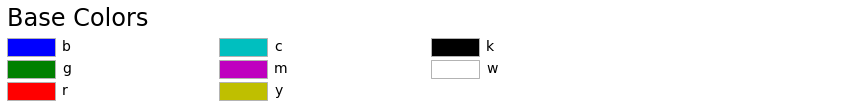

In [53]:
_ = plot_colortable(mcolors.BASE_COLORS, "Base Colors",
                sort_colors=False, emptycols=1)


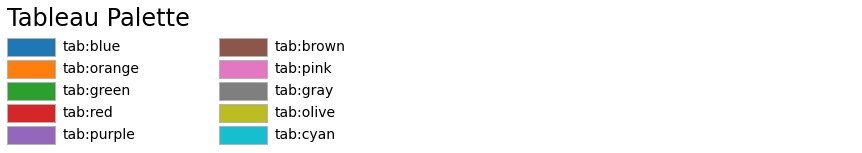

In [54]:
_ = plot_colortable(mcolors.TABLEAU_COLORS, "Tableau Palette",
                sort_colors=False, emptycols=2)



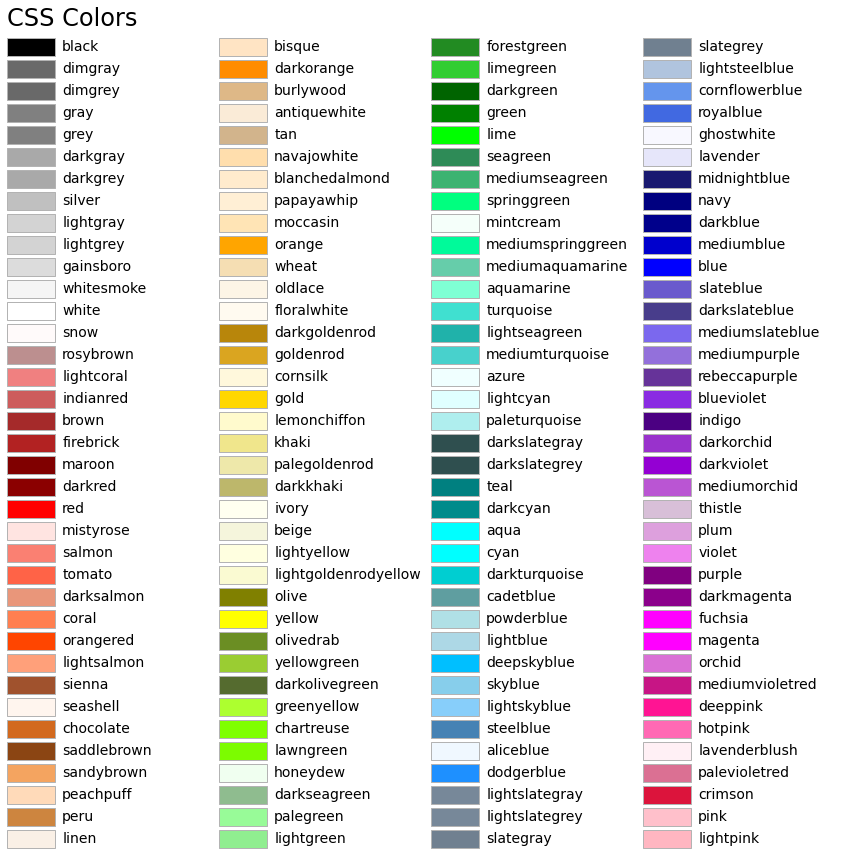

In [55]:
_ = plot_colortable(mcolors.CSS4_COLORS, "CSS Colors")

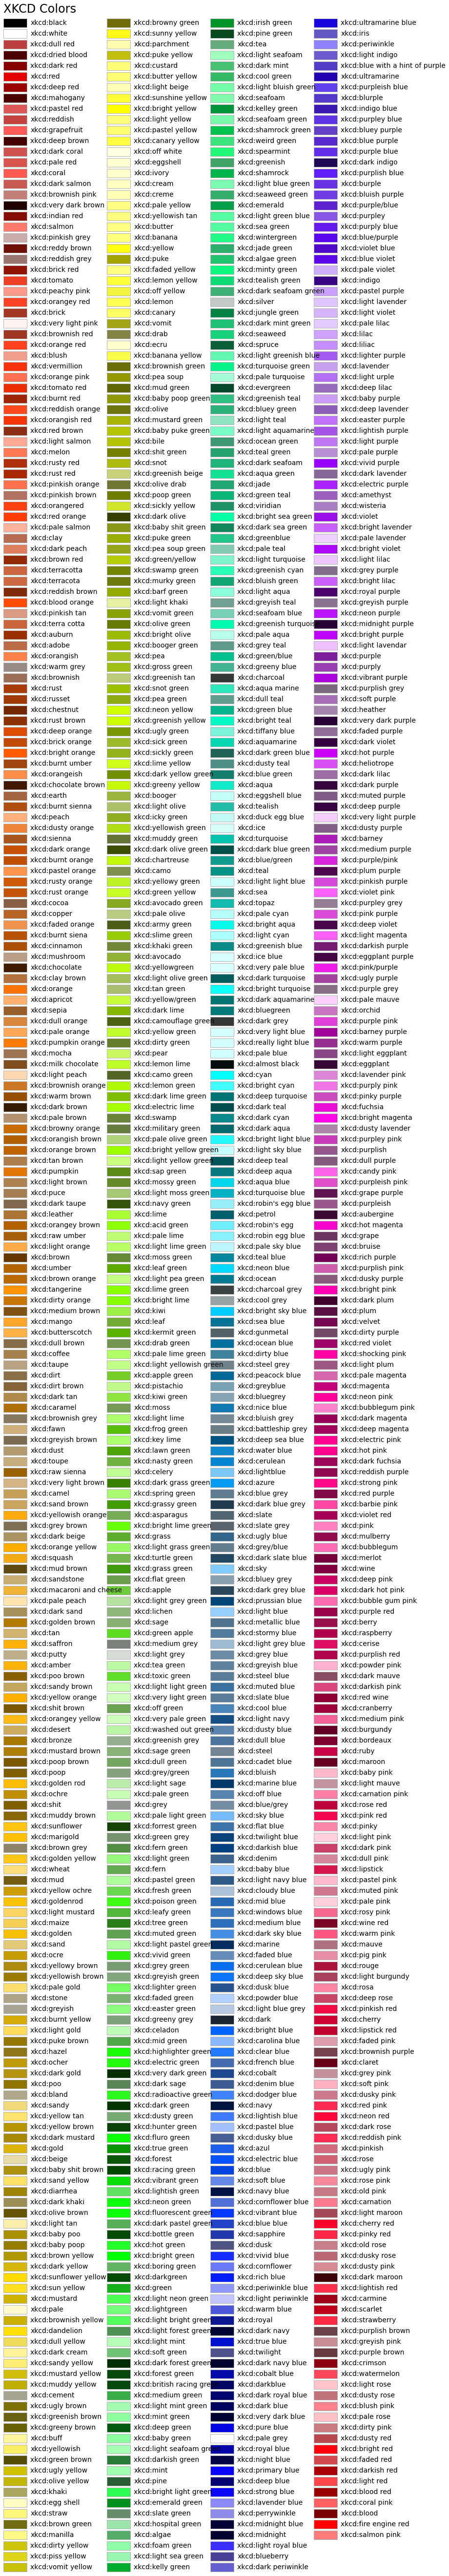

In [162]:

# Optionally plot the XKCD colors (Caution: will produce large figure)
xkcd_fig = plot_colortable(mcolors.XKCD_COLORS, "XKCD Colors")

In [163]:
# Colors: one per type of event.
# One for warnings, orange yellow.
# One for errors, neon red.
# Cool colors: 
# xkcd: pale, or css:ivory 
# xkcd: baby green
# xkcd:light periwinkle
# xkcd:pale mauve or xkcd:very light purple
# xkcd:pastel blue

In [56]:
cool_colors = [
    "xkcd:pale",
    "xkcd:baby green",
    "xkcd:light periwinkle",
    "xkcd:pale mauve",
    "xkcd:very light purple",
    "xkcd:pastel blue"
]

for cool_color in cool_colors:
    print(mcolors.to_rgb(mcolors.XKCD_COLORS[cool_color]))

(1.0, 0.9764705882352941, 0.8156862745098039)
(0.5490196078431373, 1.0, 0.6196078431372549)
(0.7568627450980392, 0.7764705882352941, 0.9882352941176471)
(0.996078431372549, 0.8156862745098039, 0.9882352941176471)
(0.9647058823529412, 0.807843137254902, 0.9882352941176471)
(0.6352941176470588, 0.7490196078431373, 0.996078431372549)


# App

In [20]:
# controller = ArrowController(steps_per_turn_alt=2052, steps_per_turn_az=200)

In [21]:
from celestial_compass.display_manager import DisplayController, round_number_to_fixed_width, format_distance, test_distance_format

In [1]:
# https://pinout.xyz/#
R_LED = 5
G_LED = 6
B_LED = 13
A_LED = 19

In [2]:
strong_colors_by_type = {
    'Mellon': "xkcd:hot green",
    'Messier': "xkcd:bright orange",
    'Mission': "xkcd:bright red",
    'Planet': "xkcd:true blue",
    'Satellite': "xkcd:very light purple",
}

pale_colors_by_type = {
    'Mellon': "xkcd:pale",
    'Messier': "xkcd:baby green",
    'Mission': "xkcd:light periwinkle",
    'Planet': "xkcd:pale mauve",
    'Satellite': "xkcd:magenta",
}

In [3]:
from celestial_compass.display_manager import DisplayController, round_number_to_fixed_width, format_distance, test_distance_format
from celestial_compass.visibility_window import VisibilityWindow
import matplotlib.colors as mcolors
from celestial_compass.arrow_controller import ArrowController, sim9dof, simstepper 
import warnings, logging

from celestial_compass.compass import CelestialCompass
from celestial_compass.observables import ObserverLLA

In [4]:
logging.basicConfig(filename='myapp.log', level=logging.DEBUG)

In [5]:

ac = ArrowController(simulate_motors=False, simulate_9dof=False)

In [6]:
SPICEYPY_AVAILABLE = False
# import warnings
# try:
#     import spiceypy as spice
#     SPICEYPY_AVAILABLE = True
# except:
#     warnings.warn("Spiceypy is not available!")

from celestial_compass.data.satellites import ObservableSatellites
if SPICEYPY_AVAILABLE:
    from celestial_compass.data.missions import ObservableMissions
else:
    from celestial_compass.data.missions_base import ObservableMissions
from celestial_compass.data.planets import ObservablePlanets
# from celestial_compass.data.small_bodies import ObservableSmallBodies
from celestial_compass.data.mellyn import ObservableMellyn    
from celestial_compass.data.messier import ObservableMessiers
    

# Observables = ObservableSatellites+ObservableMissions+ObservablePlanets+ObservableSmallBodies+ObservableMellyn+ObservableMessiers
Observables = ObservableSatellites+ObservableMissions+ObservablePlanets+ObservableMellyn+ObservableMessiers

In [9]:
_observer = ObservableMellyn[4]

observer = ObserverLLA(
    lat_rad = _observer.data['lat_deg_N']*np.pi/180.,
    lon_rad = _observer.data['lon_deg_E']*np.pi/180.,
    alt_m  = _observer.data['alt_m'],
)

In [10]:
cc = CelestialCompass(
        controller= ac,
        observer = observer,
        observables = Observables,
        time_on_target_s=15.,
        target_list_length_s=60,
        check_visible= False,
#         visibility_window=VisibilityWindow(min_alt_rad=0.),
        simulated_display=False,
        led_pins_rgba = (R_LED, G_LED, B_LED, A_LED),
        led_colors=strong_colors_by_type,
    )

In [11]:
cc.run()

KeyboardInterrupt: 

In [32]:
del cc

NameError: name 'cc' is not defined

In [33]:
import gc
gc.collect()

219

In [51]:
[_s['observable'] for _s in cc.schedule]

[Observable: Eagle Nebula (M16)
 Star(ra=-85.30000000000001, dec=-13.7833, epoch=2451545.0),
 Observable: Praesepe (M44)
 Star(ra=130.025, dec=19.9833, epoch=2451545.0),
 Observable: Saturn
 '/home/frossi/Documents/Personal/Arrows/data/de440s.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 6 SATURN BARYCENTER,
 Observable: (253) Mathilde
 Sum of 2 vectors:
  '/home/frossi/Documents/Personal/Arrows/data/de440.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
  _KeplerOrbit 10 SUN -> str,
 Observable: (7) Iris
 Sum of 2 vectors:
  '/home/frossi/Documents/Personal/Arrows/data/de440.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
  _KeplerOrbit 10 SUN -> str,
 Observable: (8) Flora
 Sum of 2 vectors:
  '/home/frossi/Documents/Personal/Arrows/data/de440.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
  _KeplerOrbit 10 SUN -> str,
 Observable: (15) Eunomia
 Sum of 2 vectors:
  '/home/frossi/Documents/Personal/Arrows/data/de440.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
  _KeplerOrbit 10 SUN

In [173]:
import luma.emulator.device
device = luma.emulator.device.capture()

dc = DisplayController(device=device)

In [174]:
_observable = cc.schedule[0]['observable']

In [175]:
import skyfield
dc.display_observable_data(
    observable_name=_observable.name,
    observable_type=_observable.type_name,
    observable_dist=format_distance(skyfield.units.Distance(au=103)),
)
# dc.display_observable("Messier")

In [54]:
_observable['observable'].type_name

'Messier'

In [63]:
cc.run()

KeyboardInterrupt: 

# LEDs

In [1]:
# https://pinout.xyz/#
R_LED = 5
G_LED = 6
B_LED = 13
A_LED = 19

In [3]:
# from celestial_compass.led_manager import RGBManager


In [4]:
ledmanager = RGBManager(
    R_LED=R_LED,
    G_LED=G_LED,
    B_LED=B_LED,
    A_LED=A_LED,
)

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.


In [5]:
ledmanager.display_color([1,1,1])


In [5]:
ledmanager.breathe_color([1,0,1], frequency_hz=0.1, duration_s=10.)


In [9]:
import time
sf = False
ledmanager.breathe_color_async([1,0,0], frequency_hz=0.1, duration_s=40.)
time.sleep(10)
print("Stopping")
ledmanager._keep_breathing = False
print("Outside")

Starting thread
Joining thread
Done
Stopping
Outside


In [9]:
import matplotlib.colors as mcolors


cool_colors = [
    "xkcd:pale",
    "xkcd:baby green",
    "xkcd:light periwinkle",
    "xkcd:pale mauve",
    "xkcd:very light purple",
    "xkcd:pastel blue"
]

for cool_color in cool_colors:
    print(cool_color)
    rgb_color = mcolors.to_rgb(mcolors.XKCD_COLORS[cool_color])
    ledmanager.breathe_color(rgb_color, frequency_hz=0.1, duration_s=10.)

xkcd:pale
xkcd:baby green
xkcd:light periwinkle
xkcd:pale mauve
xkcd:very light purple
xkcd:pastel blue


In [14]:
ledmanager.breathe_color([0,0,1], frequency_hz=0.1, duration_s=20.)


In [15]:
ledmanager.display_color([0,0,0])


# App

In [1]:
"""
 Copyright (C) 2021 Federico Rossi (347N)
 
 This file is part of Trovastelle.
 
 Trovastelle is free software: you can redistribute it and/or modify
 it under the terms of the GNU General Public License as published by
 the Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.
 
 Trovastelle is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 GNU General Public License for more details.
 
 You should have received a copy of the GNU General Public License
 along with Trovastelle.  If not, see <http://www.gnu.org/licenses/>.
"""


from celestial_compass.display_manager import DisplayController, round_number_to_fixed_width, format_distance, test_distance_format
from celestial_compass.visibility_window import VisibilityWindow
import matplotlib.colors as mcolors
from celestial_compass.arrow_controller import ArrowController, sim9dof, simstepper 
import warnings, logging

from celestial_compass.compass import CelestialCompass
from celestial_compass.observables import ObserverLLA

import numpy as np

    

In [2]:

# Logging config
logging.basicConfig(filename='myapp.log', level=logging.DEBUG)

# LED config
logging.debug("Configuring LEDs")
R_LED = 5
G_LED = 6
B_LED = 13
A_LED = 19
strong_colors_by_type = {
    'Mellon': "xkcd:hot green",
    'Messier': "xkcd:bright orange",
    'Mission': "xkcd:bright red",
    'Planet': "xkcd:true blue",
    'Satellite': "xkcd:very light purple",
}

pale_colors_by_type = {
    'Mellon': "xkcd:pale",
    'Messier': "xkcd:baby green",
    'Mission': "xkcd:light periwinkle",
    'Planet': "xkcd:pale mauve",
    'Satellite': "xkcd:magenta",
}

logging.debug("Configuring display")
display_controller = DisplayController()
display_controller.display_fullscreen_text("Trovastelle")


logging.debug("Configuring observables")
# Observables config
SPICEYPY_AVAILABLE = False
try:
    import spiceypy as spice
    SPICEYPY_AVAILABLE = True
except:
    logging.warning("Spiceypy is not available!")

from celestial_compass.data.satellites import ObservableSatellites
if SPICEYPY_AVAILABLE:
    from celestial_compass.data.missions import ObservableMissions
else:
    from celestial_compass.data.missions_base import ObservableMissions
from celestial_compass.data.planets import ObservablePlanets
# from celestial_compass.data.small_bodies import ObservableSmallBodies
from celestial_compass.data.mellyn import ObservableMellyn    
from celestial_compass.data.messier import ObservableMessiers


# Observables = ObservableSatellites+ObservableMissions+ObservablePlanets+ObservableSmallBodies+ObservableMellyn+ObservableMessiers
Observables = ObservableSatellites+ObservableMissions+ObservablePlanets+ObservableMellyn+ObservableMessiers

logging.debug("Configuring observer")
# Observer: Marzia
_observer = ObservableMellyn[4]

observer = ObserverLLA(
    lat_rad = _observer.data['lat_deg_N']*np.pi/180.,
    lon_rad = _observer.data['lon_deg_E']*np.pi/180.,
    alt_m  = _observer.data['alt_m'],
)

logging.debug("Configuring arrow controller")
# Arrow controller
ac = ArrowController(
    simulate_motors=False,
    simulate_9dof=False,
    steps_per_turn_alt=2052,
    steps_per_turn_az=int(200*16/6),
)

logging.debug("Configuring Trovastelle")
# Full controller
cc = CelestialCompass(
        controller= ac,
        observer = observer,
        observables = Observables,
        time_on_target_s=15.,
        target_list_length_s=60,
        check_visible= False,
#         visibility_window=VisibilityWindow(min_alt_rad=0.),
        display_controller=display_controller,
        simulated_display=False,
        led_pins_rgba = (R_LED, G_LED, B_LED, A_LED),
        led_colors=strong_colors_by_type,
    )

logging.debug("Running! Trovastelle")


In [3]:
cc.calibrate()

Azimuth: raw -0.04937814975355219 deg, corrected 2.618204301949723 deg, clamped 2.618204301949712 deg
(0, 0, 0, 0)
(0, 3, 0, 1)
(0, 3, 0, 1)
Azimuth: raw 6.323931934672546 deg, corrected 8.99151438637582 deg, clamped 8.991514386375826 deg
(0, 3, 0, 1)
(3, 3, 0, 2)
(3, 3, 0, 2)
Azimuth: raw -129.24574550743895 deg, corrected -126.57816305573566 deg, clamped -126.57816305573566 deg
(3, 3, 0, 2)
(3, 3, 0, 2)
(3, 3, 0, 3)
Azimuth: raw -129.5227129768644 deg, corrected -126.8551305251611 deg, clamped -126.8551305251611 deg
(3, 3, 0, 3)
(3, 3, 1, 3)
(3, 3, 1, 3)
Azimuth: raw -176.9308491830928 deg, corrected -174.2632667313895 deg, clamped -174.2632667313895 deg
(3, 3, 1, 3)
Azimuth: raw -67.59828369603761 deg, corrected -64.93070124433433 deg, clamped -64.93070124433433 deg
Azimuth: raw -67.59926120171029 deg, corrected -64.93167875000702 deg, clamped -64.93167875000701 deg
Azimuth: raw -67.6056978062544 deg, corrected -64.93811535455112 deg, clamped -64.93811535455112 deg
Azimuth: raw 8.53

In [ ]:
cc.run()

Azimuth: raw 3.3353031385341203 deg, corrected 6.002885590237396 deg, clamped 6.002885590237405 deg
Azimuth: raw 65.05428728993998 deg, corrected 67.72186974164325 deg, clamped 67.72186974164327 deg
Azimuth: raw -43.72166695931473 deg, corrected -41.05408450761145 deg, clamped -41.05408450761144 deg
Azimuth: raw 50.86084337996461 deg, corrected 53.52842583166788 deg, clamped 53.52842583166786 deg
Azimuth: raw 72.47379242626609 deg, corrected 75.14137487796935 deg, clamped 75.14137487796937 deg
Azimuth: raw 85.21364751803995 deg, corrected 87.88122996974323 deg, clamped 87.88122996974322 deg
Azimuth: raw -39.571073113692655 deg, corrected -36.90349066198937 deg, clamped -36.90349066198938 deg
Azimuth: raw 11.958155704566584 deg, corrected 14.62573815626986 deg, clamped 14.62573815626986 deg
Azimuth: raw 41.402082993626834 deg, corrected 44.069665445330116 deg, clamped 44.06966544533011 deg
Azimuth: raw -6.43775134337115 deg, corrected -3.770168891667874 deg, clamped -3.770168891667866 d